In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error ,r2_score,mean_absolute_error


In [262]:

# Cargar el dataset
data = pd.read_csv("Temp_Asu20092021.csv")

# Convertir la columna 'Fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Establecer la columna 'Fecha' como índice
data.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019 en adelante
data = data[data.index.year >= 2019]



In [263]:
#Buscando carateristicas relevantes
# Crear características derivadas
data['Dia'] = data.index.dayofweek  # 0 = Lunes, 6 = Domingo
data['Mes'] = data.index.month
# Resamplear el conjunto de datos a intervalos diarios y calcular la temperatura máxima diaria
daily_data = data.resample('D').agg({
    'Temperatura': 'max',       # Temperatura máxima del día
    'Humedad': 'mean'          # Humedad media del día
})

# Calcular el percentil 95 de la humedad y de la temperatura
daily_data['Dia'] = daily_data.index.dayofweek
daily_data['Mes'] = daily_data.index.month
print(daily_data)
# Eliminar filas con valores faltantes después del resampleo
daily_data.dropna(inplace=True)

# Desplazar la variable objetivo (Temperatura máxima)
data = data.resample('D').agg({
    'Temperatura': 'max',       # Temperatura máxima del día
})
salida = data[['Temperatura']].shift(-1)

# Definir características (features) y variable objetivo (target)
X = daily_data[[ 'Humedad', 'Temperatura','Dia']].values[:-1]
y = salida.values[:-1]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



            Temperatura    Humedad  Dia  Hora  Mes
Fecha                                             
2019-01-01    37.517422  56.955561    1     0    1
2019-01-02    37.610636  51.152699    2     0    1
2019-01-03    38.163652  45.634246    3     0    1
2019-01-04    37.351168  43.897100    4     0    1
2019-01-05    34.843885  67.379373    5     0    1
...                 ...        ...  ...   ...  ...
2021-12-27    39.333956  17.983852    0     0   12
2021-12-28    40.783501  23.484268    1     0   12
2021-12-29    42.042177  19.802980    2     0   12
2021-12-30    43.197525  33.273657    3     0   12
2021-12-31    41.244712  49.192770    4     0   12

[1096 rows x 5 columns]


In [264]:
# Dividir los datos en conjuntos de entrenamiento y validación
train_indices = (daily_data.index.year <= 2020)[:-1]
val_indices = (daily_data.index.year == 2021)[:-1]

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

# Definir el modelo de regresión Ridge
ridge = Ridge()

# Definir la cuadrícula de parámetros para GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Regularización L2
}

# Usar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de validación
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Calcular el MSE para la temperatura máxima
mse_temp = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Squared Error para la Temperatura en validación: {mse_temp}")
print(f"Mean Absolute Error en validación: {mae}")

# Imprimir resultados de predicción
results = pd.DataFrame({
    'Temperatura Real': y_val.flatten(),
    'Predicción Temperatura': y_pred.flatten()
}, index=daily_data.index[1:][val_indices])  # Asegúrate de ajustar el índice correctamente

print("\nResultados de predicción:")
print(results)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejores hiperparámetros:
{'alpha': 0.01}
Mean Squared Error para la Temperatura en validación: 16.626178683593366
Mean Absolute Error en validación: 3.0147067328036856

Resultados de predicción:
            Temperatura Real  Predicción Temperatura
Fecha                                               
2021-01-02         37.035863               33.361134
2021-01-03         40.793450               35.936991
2021-01-04         29.466054               38.836288
2021-01-05         29.927540               29.858866
2021-01-06         34.018225               29.801769
...                      ...                     ...
2021-12-27         39.333956               38.435318
2021-12-28         40.783501               38.055258
2021-12-29         42.042177               39.087669
2021-12-30         43.197525               40.117450
2021-12-31         41.244712               40.798148

[364 rows x 2 columns]


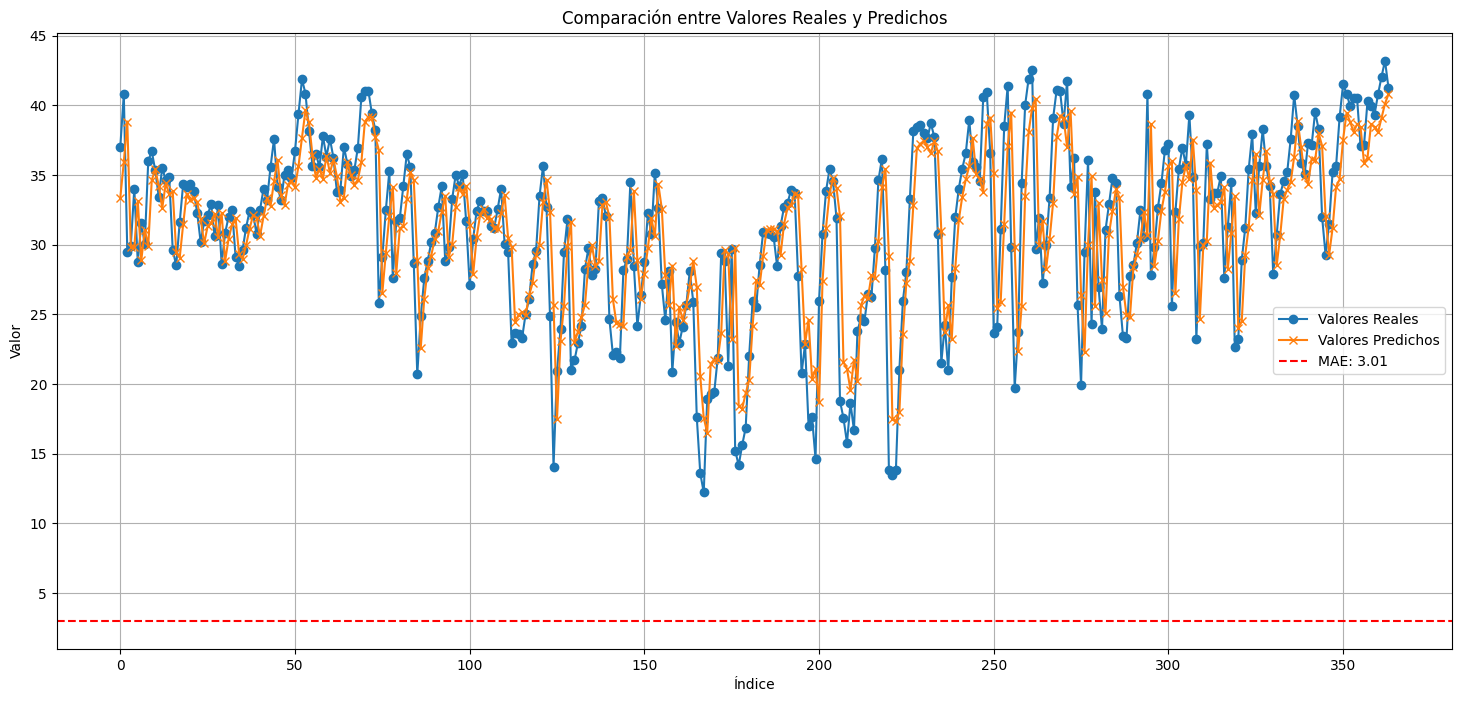

In [265]:
#Grafico
plt.figure(figsize=(18, 8))
plt.plot(y_val, label='Valores Reales', marker='o')
plt.plot(y_pred, label='Valores Predichos', marker='x')
plt.title('Comparación entre Valores Reales y Predichos')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.axhline(y=mae, color='r', linestyle='--', label=f'MAE: {mae:.2f}')
plt.legend()
plt.grid()
plt.show()
